# GP Multiple runs on an arbitrary Symbolic Regression Problem.

Now we add elitism to our system. Note that this is packaged up as an other algorithm, so it will work with virtually any other notebook we've looked at. 

The key thing to note is how we include that functionality, as it is **not** a standard algorithm in DEAP.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/ipykernel_57128/3391910190.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Install DEAP. 

In [2]:
# !pip install deap

Python will import from files in the working directory, so we change to the one we need.

Import our tools. 

In [3]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv



import matplotlib.pyplot as plt

import itertools
import networkx as nx

Set our Genetic Programming parameters, one of which is now the number of runs.

In [4]:
# Genetic Programming constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10

N_RUNS = 30

Set the random seed. 

In [5]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [6]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Read in the data. Notice that this time we can use the path, so there's no need to change to that folder.

In [7]:
with open("./input.csv") as inputData:
    n_rows = sum(1 for line in inputData)
with open("./input.csv") as inputData:
    reader = csv.reader(inputData)
    data = list(list(float(elem) for elem in row) for row in reader)
    dataSorted = sorted(data, key = lambda x: x[0])
print(dataSorted)

[[0.05, -5.920472905375246e-06], [0.15, -0.0004197490074396078], [0.25, -0.002744011962215962], [0.35, -0.008657128698830847], [0.45, -0.01888024838080345], [0.55, -0.03281107258572483], [0.65, -0.04893233110534319], [0.75, -0.06560096236716338], [0.85, -0.08166740530354051], [0.95, -0.09650694284366339], [1.05, -0.109383732295163], [1.15, -0.1184462034256205], [1.25, -0.1198965923123214], [1.35, -0.1078791480794438], [1.45, -0.07538681808122603], [1.55, -0.01609080392499869], [1.65, 0.07339461083608066], [1.75, 0.1915363368441183], [1.85, 0.3309083626081094], [1.95, 0.4786681161315149], [2.05, 0.6185024362862599], [2.15, 0.733608667330639], [2.25, 0.809947806298645], [2.35, 0.8389089510601118], [2.45, 0.8186871380016217], [2.55, 0.7540465107814242], [2.65, 0.6546009929076181], [2.75, 0.5321544028706404], [2.85, 0.3978806420930439], [2.95, 0.2601276974469659], [3.05, 0.1234051649414878], [3.15, -0.01126090293203677], [3.25, -0.1448333887352612], [3.35, -0.278182980554089], [3.45, -0.41

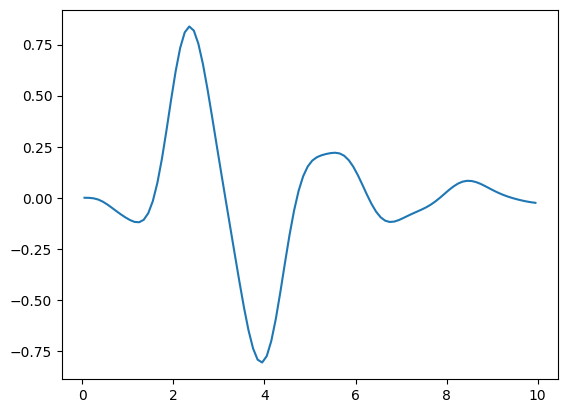

In [8]:
dataNumpy = numpy.array(dataSorted)
plt.plot(dataNumpy[:,0], dataNumpy[:,1])

Define our fitness function.

In [9]:
def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the sum of squared difference between the expression and the target values
    # [print(row[-1]) for row in data]
    diff = sum((func(*row[:-1]) - row[-1])**2 for row in data)
    error = diff/n_rows
    if (error>10):
        error=10
    #return error, individual.height
    nodes, edges, labels = gp.graph(individual)
    return error, len(nodes)

Define a protected division function.

In [10]:
# Protected functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1


def psin(n):
    try:
        return numpy.sin(n)
    except Exception:
        return numpy.nan

def pcos(n):
    try:
        return numpy.cos(n)
    except Exception:
        return numpy.nan

def pow2(n):
    return operator.pow(n, 2)

Add our functions and terminals. 

In [11]:
pset = gp.PrimitiveSet("MAIN", 1) # number of inputs!!!
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.random())

/home/sprince0031/.local/lib/python3.10/site-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [12]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg)
#toolbox.register("select", tools.selNSGA2)
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Create our statistics. These are a bit more complex than the GA ones because we want to keep track of fitness and size for all runs.

In [13]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

bestIndividualsForNRuns = []

Now the magic happens and we run **N_RUNS** times. Always start with a small number of runs and generations to make sure that everything is working properly before you commit to a larger number. That way, if something goes horribly wrong, Python won't replicate it 30 times before giving you back control!

In [14]:
for r in range(0, N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


    # Create our statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    
    
    # It's usually a good idea to turn off verbose when conducting multiple runs
    population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=False)
    
    #maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
    meanFitnessValues, stdFitnessValues, minFitnessValues, maxFitnessValues  = logbook.chapters['fitness'].select("avg", "std", "min", "max")
    meanSizeValues, stdSizeValues, minSizeValues, maxSizeValues  = logbook.chapters['size'].select("avg", "std", "min", "max")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    stdListFitness.append(stdFitnessValues)
    minListFitness.append(minFitnessValues)
    maxListFitness.append(maxFitnessValues)
    
    avgListSize.append(meanSizeValues)
    stdListSize.append(stdSizeValues)
    minListSize.append(minSizeValues)
    maxListSize.append(maxSizeValues)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])

    bestInd = toolbox.compile(expr=best)
    bestIndData = [bestInd(row[0]) for row in dataSorted]
    bestIndividualsForNRuns.append((bestIndData, best.fitness.values[0]))
    



Currently on run 0 of 30
-- Best Individual =  mul(0.6127054166079398, sin(sub(sub(ARG0, sin(sub(ARG0, sub(ARG0, sin(sin(sub(ARG0, sin(sin(ARG0))))))))), sin(sub(ARG0, sub(sin(sin(sin(sub(ARG0, sub(ARG0, sin(sub(0.021601040321409526, sub(sin(sub(ARG0, 0.021601040321409526)), neg(ARG0))))))))), sin(sub(sub(sub(ARG0, 0.021601040321409526), sin(sub(ARG0, sub(ARG0, sin(sin(ARG0)))))), sin(ARG0)))))))))
-- length=55, height=16
-- Best Fitness =  0.03101862904895702


Currently on run 1 of 30
-- Best Individual =  mul(sin(mul(sin(sin(sin(sin(sin(sin(sin(sin(sin(mul(sin(sin(sin(sin(ARG0)))), ARG0)))))))))), ARG0)), 0.30161002020986494)
-- length=21, height=17
-- Best Fitness =  0.06272246201198345


Currently on run 2 of 30
-- Best Individual =  mul(sin(sin(sin(sin(sin(0.4024286398868344))))), sin(mul(ARG0, sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(add(add(0.840432507715974, sin(ARG0)), cos(ARG0))))))))))))))))
-- length=28, height=17
-- Best Fitness =  0.051624639831384427


Currently on

Create our graphs using the averages across all the runs. Notice how we use standard deviation to show how much variation there is in the runs. 

Notice that if there's a big discrepancy between best and average the graphs can look like there's virtually no variation in the best score. If this happens, the first thing to do is verify if that is actually happening; you can do that by commenting out this line:

**plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")**

Best individual from all runs: ([0.005096932980793865, -0.009414904054373426, -0.02204926809668506, -0.031938608749495154, -0.039677197339087276, -0.0468791432133487, -0.055329494907200884, -0.06620868748812953, -0.07948515550780212, -0.09345747548024248, -0.10454072069159413, -0.10750233862744325, -0.09631677586782014, -0.06559182008944549, -0.012210954985739791, 0.06338260538097998, 0.15679608325410285, 0.2604067039730817, 0.3649520275980937, 0.4613986077822275, 0.5424214877271486, 0.6030597977314681, 0.6405258336024171, 0.6535237704368135, 0.641592874602435, 0.6048561970295541, 0.5442102833988959, 0.46165710545301525, 0.3604083130429483, 0.24464006224895746, 0.11909393933285937, -0.011204811027522485, -0.14103387666902387, -0.2650093140418977, -0.37775383582238176, -0.474241361379526, -0.550199892542796, -0.6024205137940016, -0.6289154406966332, -0.6289770556877494, -0.6032179088223386, -0.553619197010901, -0.483540696671377, -0.3976041149987711, -0.30138014188563267, -0.20087899680

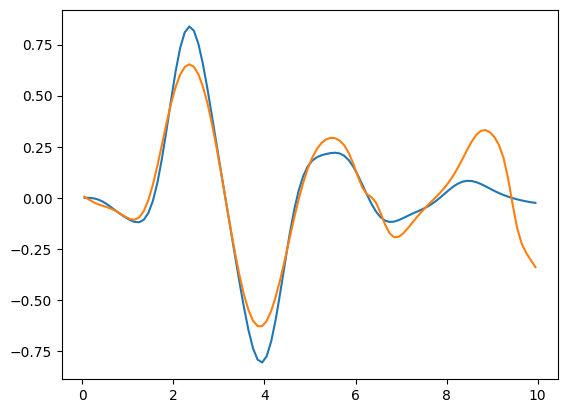

In [15]:
minBest = min(bestIndividualsForNRuns, key = lambda val: val[1])
print(f'Best individual from all runs: {minBest}')

plt.plot(dataNumpy[:,0], dataNumpy[:,1])
# for bestInd in bestIndividualsForNRuns:
#     plt.plot(dataNumpy[:,0], bestInd[0])
plt.plot(dataNumpy[:,0], minBest[0])
plt.show()

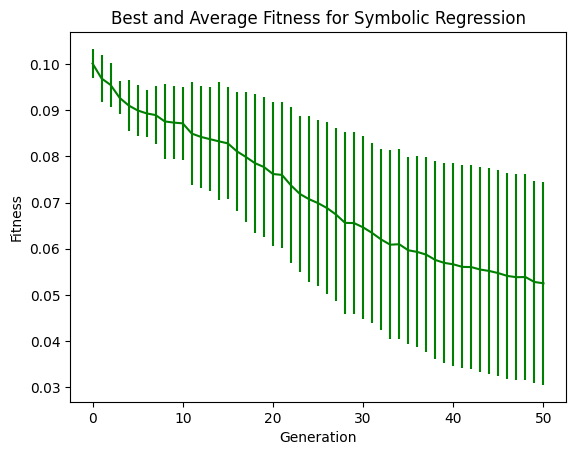

In [16]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Symbolic Regression')
#plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()

Show the graph for size.

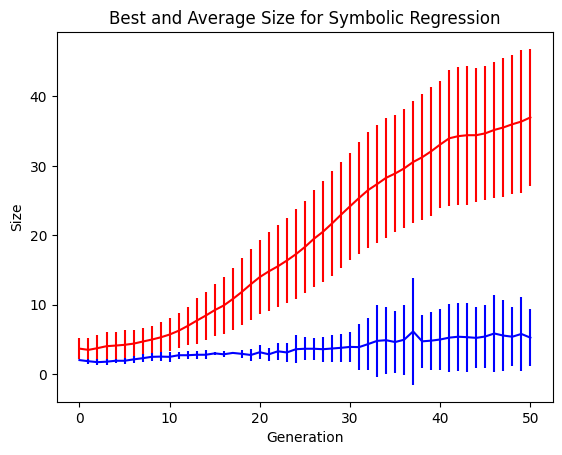

In [17]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListSize)
stdArray = numpy.array(stdListSize)
minArray = numpy.array(minListSize)
maxArray = numpy.array(maxListSize)
plt.xlabel('Generation')
plt.ylabel('Size')
plt.title('Best and Average Size for Symbolic Regression')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Blue")
plt.show()